# Attention et CNN pour l'extraction de relation

Dans ce notebook nous allons implémenter un modèle CNN auquel s'ajoute le mécanisme d'attention. Ce modèle est inspiré de [cet article](https://www.aclweb.org/anthology/C16-1238.pdf), néanmoins contrairement à ce qui a été fait dans l'article, nous n'utiliserons pas les tags POS.



### Architecture générale du modèle

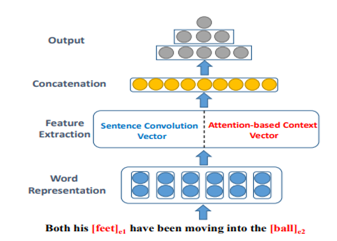

### CNN

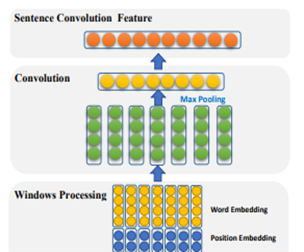


### Attention 

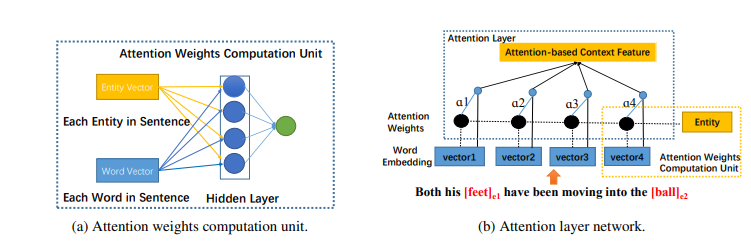

## Préparation des données

### Import des données 

On charge les données comme dans le notebook précédent. On charge les tokens, les relations ainsi que les positions des entités dans la phrases.

In [ ]:
from google.colab import  drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
my_path = "/drive/My Drive/"

In [ ]:
from tqdm import tqdm
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import re
import argparse
import torch
import os
import random
import json
import numpy as np
def sentence_process(sentence):
    e1 = re.findall(r'<e1>(.*)</e1>', sentence)[0]
    e2 = re.findall(r'<e2>(.*)</e2>', sentence)[0]
    sentence = sentence.replace('<e1>' + e1 + '</e1>', ' <e1> ' + e1 + ' </e1> ', 1)
    sentence = sentence.replace('<e2>' + e2 + '</e2>', ' <e2> ' + e2 + ' </e2> ', 1)
    sentence = ''.join(sentence)
    sentence = sentence.replace('< e1 >', '<e1>')
    sentence = sentence.replace('< e2 >', '<e2>')
    sentence = sentence.replace('< /e1 >', '</e1>')
    sentence = sentence.replace('< /e2 >', '</e2>')
    #sentence = sentence
    token = sentence.split()
 

    assert '<e1>' in sentence
    assert '<e2>' in sentence
    assert '</e1>' in sentence
    assert '</e2>' in sentence

    return  remove_postion_indicators(token)


def remove_postion_indicators(token):
    subj_start = subj_end = obj_start = obj_end = 0
    pure_token = []
    pure_pos = []
    for i, word in enumerate(token):
        if '<e1>' == word:
            subj_start = len(pure_token)
            continue
        if '</e1>' == word:
            subj_end = len(pure_token) - 1
            continue
        if '<e2>' in word:
            obj_start = len(pure_token)
            continue
        if '</e2>' in word:
            obj_end = len(pure_token) - 1
            continue
        pure_token.append(word)
       
    res = dict(
        token=pure_token,
        subj_start=subj_start,
        subj_end=subj_end,
        obj_start=obj_start,
        obj_end=obj_end
    )

    return res

def convert(src_file, des_file):
    with open(src_file, 'r', encoding='utf-8') as fr:
        file_data = fr.readlines()

    with open(des_file, 'w', encoding='utf-8') as fw:
        for i in tqdm(range(0, len(file_data), 3)):
            meta = {}
            s = file_data[i].strip().split('  ')
            assert len(s) == 2
            meta['id'] = s[0]
            
            meta['relation'] = file_data[i+1].strip()
        
            meta['comment'] = file_data[i+2].strip()
       
            sen_res = sentence_process(s[1])
         
           
            json.dump({**meta, **sen_res}, fw, ensure_ascii=False)
            fw.write('\n')



path_train = my_path + 'train.txt'
path_test = my_path +'pre_test.txt'
path_valid = my_path +'pre_test.txt'

convert(path_train, my_path + '/train.json')
convert(path_test, my_path + '/test.json')
convert(path_test, my_path + '/valid.json')

100%|██████████| 5152/5152 [00:01<00:00, 4264.68it/s]


### Import du Word Embedding pré-entraîner

In [ ]:
class WordEmbeddingLoader(object):


    def __init__(self, embedding_path, word_dim, min_freq):
        self.embedding_path = embedding_path  
        self.embedding_dim = word_dim 
        self.data_dir = my_path
        self.min_freq = min_freq

    def __build_vocab(self):
        vocab = {}
        #filename = ['train.json', 'test.json']
        filename = ['train.json']
        for fn in filename:
            with open(os.path.join(self.data_dir, fn), 'r', encoding='utf-8') as fr:
                for line in fr:
                    line = json.loads(line.strip())
                    sentence = line['token']
                    for token in sentence:
                        token = token.lower()
                        vocab[token] = vocab.get(token, 0) + 1
        vocab = set([token for token in vocab if vocab[token] > self.min_freq])
        return vocab

    def load_embedding(self):
        vocab = self.__build_vocab()
        token2id = {}
        token2id['PAD'] = len(token2id) #0
        token2id['UNK'] = len(token2id) #1
        token_emb = []
        with open(self.embedding_path, 'r', encoding='utf-8') as fr:
            for line in fr:
                line = line.strip().split()
                if len(line) != self.embedding_dim + 1:
                    continue
                if line[0] not in vocab:
                    continue
                token2id[line[0]] = len(token2id)
                token_emb.append(np.asarray(line[1:], dtype=np.float32))
        token_emb = np.stack(token_emb).reshape(-1, self.embedding_dim)
        
        # pour les caractères spéciaux, les embeddings sont une distribution normale aléatoire
        special_emb = np.random.uniform(-0.1, 0.1, size=(2, self.embedding_dim))
        
        token_emb = np.concatenate((special_emb, token_emb), axis=0)
        token_emb = token_emb.astype(np.float32).reshape(-1, self.embedding_dim)
        token_emb = torch.from_numpy(token_emb)
        return token2id, token_emb


In [ ]:
EMBEDDING_PATH = my_path +'/glove.6B.300d.txt'
WORD_DIM = 300
MIN_FREQ = 1

word2id, word_vec = WordEmbeddingLoader(EMBEDDING_PATH, WORD_DIM, MIN_FREQ).load_embedding()

In [ ]:
torch.autograd.set_detect_anomaly(True)

### Import des relations

In [ ]:
class RelationLoader(object):
    def __init__(self):
        self.data_dir = my_path 

    def __load_relation(self):
        relation_file = os.path.join(self.data_dir, 'relation2id.txt')
        rel2id = {}
        id2rel = {}
        with open(relation_file, 'r', encoding='utf-8') as fr:
            for line in fr:
                relation, id_s = line.strip().split()
                id_d = int(id_s)
                rel2id[relation] = id_d
                id2rel[id_d] = relation
        return rel2id, id2rel, len(rel2id)

    def get_relation(self):
        return self.__load_relation()

In [ ]:
rel2id, id2rel, class_num = RelationLoader().get_relation()

In [ ]:
rel2id

{'<pad>': 0,
 'authored(e1,e2)': 20,
 'authored(e2,e1)': 19,
 'belongsto(e1,e2)': 25,
 'belongsto(e2,e1)': 6,
 'exploits(e1,e2)': 9,
 'exploits(e2,e1)': 11,
 'hasattacklocation(e1,e2)': 7,
 'hasattacklocation(e2,e1)': 5,
 'hasattacktime(e1,e2)': 1,
 'hasattacktime(e2,e1)': 14,
 'hascharacteristics(e1,e2)': 15,
 'hascharacteristics(e2,e1)': 21,
 'hasproduct(e1,e2)': 13,
 'hasproduct(e2,e1)': 18,
 'hasvulnerability(e1,e2)': 3,
 'hasvulnerability(e2,e1)': 10,
 'indicates(e1,e2)': 12,
 'indicates(e2,e1)': 2,
 'involvesmalware(e1,e2)': 22,
 'involvesmalware(e2,e1)': 23,
 'other': 8,
 'targets(e1,e2)': 4,
 'targets(e2,e1)': 17,
 'usesmalware(e1,e2)': 24,
 'usesmalware(e2,e1)': 16}

### Traitement des données et itérateurs

In [ ]:
class BrevetsDateset(Dataset):
    def __init__(self, filename, rel2id, word2id, max_len, pos_dis):
        self.filename = filename
        self.rel2id = rel2id
        self.word2id = word2id
        self.max_len = max_len
        self.pos_dis = pos_dis
        self.data_dir = my_path 
        self.dataset, self.label = self.__load_data()

    # Position des mots par rapport aux entités e1 et e2
    def __get_pos_index(self, x):
        if x < -self.pos_dis:
            return 0
        if x >= -self.pos_dis and x <= self.pos_dis:
            return x + self.pos_dis + 1
        if x > self.pos_dis:
            return 2 * self.pos_dis + 2

    def __get_relative_pos(self, x, entity_pos):
        if x < entity_pos[0]:
            return self.__get_pos_index(x-entity_pos[0])
        elif x > entity_pos[1]:
            return self.__get_pos_index(x-entity_pos[1])
        else:
            return self.__get_pos_index(0)

    def __symbolize_sentence(self, e1_pos, e2_pos, sentence):
        """
            Args:
                e1_pos (tuple) span of e1
                e2_pos (tuple) span of e2
                sentence (list)
             
        """
        # mask vaut 2 entre les deux entités, 3 après la dernière entité, et 1 avant la première
        mask = [1] * len(sentence)
        if e1_pos[0] < e2_pos[0]:
            for i in range(e1_pos[0], e2_pos[1]+1):
                mask[i] = 2
            for i in range(e2_pos[1]+1, len(sentence)):
                mask[i] = 3
        else:
            for i in range(e2_pos[0], e1_pos[1]+1):
                mask[i] = 2
            for i in range(e1_pos[1]+1, len(sentence)):
                mask[i] = 3
        length = min(self.max_len, len(sentence))
        
        # e1_mask, e2_mask valent 1 à l'endroit de la phrase où l'entité 1 (resp 2) est présente 
        e1_mask = [0] * self.max_len
        e2_mask = [0] * self.max_len
        for i in range(e1_pos[0], e1_pos[1]+1):
            if i < length:
                e1_mask[i] = 1
        for i in range(e2_pos[0], e2_pos[1]+1):
            if i < length:
                e2_mask[i] = 1

        words = []
        pos1 = []
        pos2 = []
       
        mask = mask[:length]

        for i in range(length):
            words.append(self.word2id.get(sentence[i].lower(), self.word2id['UNK']))
            pos1.append(self.__get_relative_pos(i, e1_pos))
            pos2.append(self.__get_relative_pos(i, e2_pos))

        if length < self.max_len:
            for i in range(length, self.max_len):
                mask.append(0)  # 'PAD' mask vaut 0
                words.append(self.word2id['PAD'])

                pos1.append(self.__get_relative_pos(i, e1_pos))
                pos2.append(self.__get_relative_pos(i, e2_pos))
       
        unit = np.asarray([words, pos1, pos2, mask, e1_mask, e2_mask], dtype=np.int64)
        unit = np.reshape(unit, newshape=(1, 6, self.max_len))
        return unit

    def __load_data(self):
        path_data_file = os.path.join(self.data_dir, self.filename)
        data = []
        labels = []
        with open(path_data_file, 'r', encoding='utf-8') as fr:
            for line in fr:
                line = json.loads(line.strip())
                label = line['relation']
                sentence = line['token']
                e1_pos = (line['subj_start'], line['subj_end'])
                e2_pos = (line['obj_start'], line['obj_end'])
                label_idx = self.rel2id[label]

                one_sentence = self.__symbolize_sentence(e1_pos, e2_pos, sentence)
                data.append(one_sentence)
                labels.append(label_idx)
        
        return data, labels

    def __getitem__(self, index):
        data = self.dataset[index]
        label = self.label[index]
        return data, label

    def __len__(self):
        return len(self.label)
    
class BrevetsDataLoader(object):
    def __init__(self, rel2id, word2id, batch_size, max_len, pos_dis):
        self.rel2id = rel2id
        self.word2id = word2id
        self.batch_size = batch_size
        self.max_len = max_len
        self.pos_dis = pos_dis
    def __collate_fn(self, batch):
        data, label = zip(*batch)  # unzip the batch data
        data = list(data)
        label = list(label)
        data = torch.from_numpy(np.concatenate(data, axis=0))
        label = torch.from_numpy(np.asarray(label, dtype=np.int64))
        return data, label

    def __get_data(self, filename, shuffle=False):
        dataset = BrevetsDateset(filename, self.rel2id, self.word2id, self.max_len, self.pos_dis)
        loader = DataLoader(
            dataset=dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            num_workers=2,
            collate_fn=self.__collate_fn
        )
        return loader

    def get_train(self):
        return self.__get_data('train.json', shuffle=True)

    def get_dev(self):
        return self.__get_data('valid.json', shuffle=False)

    def get_test(self):
        return self.__get_data('test.json', shuffle=False)



In [ ]:
REL2ID = rel2id
WORD2ID = word2id
BATCH_SIZE = 32
MAX_LEN = 500
POS_DIS = 50

loader = BrevetsDataLoader(REL2ID, WORD2ID, BATCH_SIZE, MAX_LEN, POS_DIS)

test_loader = loader.get_test()
train_loader = loader.get_train()
valid_loader = loader.get_dev()

In [ ]:
from tqdm import tqdm
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import re
import argparse
import torch
import os
import random
import json
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

# Modèle

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init


class Attention_CNN(nn.Module):
    def __init__(self, word_vec, class_num, max_len, word_dim, pos_dim, pos_dis, dropout, filter_num, window):
        super().__init__()
        self.word_vec = word_vec
        self.class_num = class_num

        self.max_len = max_len
        self.word_dim = word_dim
        self.pos_dim = pos_dim
        self.pos_dis = pos_dis
     
        self.dropout_value = dropout
        self.filter_num = filter_num
        self.window = window

        self.dim = self.word_dim + 2 * self.pos_dim 

        self.word_embedding = nn.Embedding.from_pretrained(
            embeddings=self.word_vec,
            freeze=False,
        )
        self.pos1_embedding = nn.Embedding(
            num_embeddings=2 * self.pos_dis + 3,
            embedding_dim=self.pos_dim
        )
        self.pos2_embedding = nn.Embedding(
            num_embeddings=2 * self.pos_dis + 3,
            embedding_dim=self.pos_dim
        )
        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=self.filter_num,
            kernel_size=(self.window, self.dim),
            stride=(1, 1),
            bias=True,
            padding=(1, 0), 
            padding_mode='zeros'
        )
        self.maxpool = nn.MaxPool2d((self.max_len, 1))
        self.tanh = nn.Tanh()
        self.we = nn.Linear(
            in_features=self.dim * 2,
            out_features=self.dim * 2,
            bias=True
        )
        self.wa = nn.Linear(
            in_features=self.dim*2,
            out_features=1,
            bias=True
        )
        
        self.dense = nn.Linear(
            in_features=self.filter_num + 2 * self.dim,
            out_features=self.class_num,
            bias=True
        )
        # initialise les poids
        init.uniform_(self.pos1_embedding.weight, a=-0.1, b=0.1)
        init.uniform_(self.pos2_embedding.weight, a=-0.1, b=0.1)
        init.uniform_(self.conv.weight, a=-0.1, b=0.1)
        init.constant_(self.conv.bias, 0.)
        init.uniform_(self.we.weight, a=-0.1, b=0.1)
        init.constant_(self.we.bias, 0.)
        init.uniform_(self.wa.weight, a=-0.1, b=0.1)
        init.constant_(self.wa.bias, 0.)
        init.uniform_(self.dense.weight, a=-0.1, b=0.1)
        init.constant_(self.dense.bias, 0.)

    # couche embedding
    def encoder_layer(self, token, pos1, pos2):
        word_emb = self.word_embedding(token) 
        pos1_emb = self.pos1_embedding(pos1)
        pos2_emb = self.pos2_embedding(pos2)
        emb = torch.cat(tensors=[word_emb, pos1_emb, pos2_emb], dim=-1)
        return emb 
    # couche cnn
    def conv_layer(self, emb, mask):
        emb = emb.unsqueeze(dim=1)  
        conv = self.conv(emb)
        # mask, supprimer les effets de PAD'
        conv = conv.view(-1, self.filter_num, self.max_len)
        mask = mask.unsqueeze(dim=1)
        mask = mask.expand(-1, self.filter_num, -1)        
        conv = conv.masked_fill_(mask.eq(0), float('-inf')) 
        conv = conv.unsqueeze(dim=-1)
        return conv
    def single_maxpool_layer(self, conv):
        pool = self.maxpool(conv)
        pool = pool.view(-1, self.filter_num)
        return pool
    def entity_average(self, emb, e_mask):
        lengths = torch.sum(e_mask.eq(1), dim=-1).view(-1, 1)  
        lengths[lengths==0] = 1
        mask = e_mask.unsqueeze(dim=1).float() 
        sum_emb = torch.bmm(mask, emb).squeeze(dim=1)  
        avg_emb = sum_emb / lengths
        return avg_emb
  
    def attention_layer(self, emb, entity, mask):
        entity = entity.unsqueeze(dim=1).expand(-1, self.max_len, -1)
        h = torch.cat(tensors=[emb, entity], dim=-1)  
        h_flat = h.view(-1, 2*self.dim)  
        output = self.tanh(self.we(h_flat))  
        u_flat = self.wa(output)  
        u = u_flat.view(-1, self.max_len)  
        # supprimer les effets de PAD'
        att_score = u.masked_fill(mask.eq(0), float('-inf'))  
        att_weight = F.softmax(att_score, dim=-1).unsqueeze(dim=-1) 
        reps = torch.bmm(emb.transpose(1, 2), att_weight).squeeze(dim=-1) 
        return reps
    def forward(self, data):
        token = data[:, 0, :].contiguous().view(-1, self.max_len) 
        pos1 = data[:, 1, :].contiguous().view(-1, self.max_len)
        pos2 = data[:, 2, :].contiguous().view(-1, self.max_len) 
        mask = data[:, 3, :].contiguous().view(-1, self.max_len)  
        e1_mask = data[:, 4, :].contiguous().view(-1, self.max_len)
        e2_mask = data[:, 5, :].contiguous().view(-1, self.max_len)
        emb = self.encoder_layer(token, pos1, pos2)
        conv = self.conv_layer(emb, mask)
        conv = self.tanh(conv)
        pool = self.single_maxpool_layer(conv)
        e1_emb = self.entity_average(emb, e1_mask)
        e2_emb = self.entity_average(emb, e2_mask)
        e1_context = self.attention_layer(emb, e1_emb, mask)
        e2_context = self.attention_layer(emb, e2_emb, mask)
        e1_context = self.tanh(e1_context)
        e2_context = self.tanh(e2_context)
        feature = torch.cat(tensors=[pool, e1_context, e2_context], dim=-1)
        logits = self.dense(feature)
        return logits

In [ ]:
# on utilise le GPU si possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [ ]:
WORD_VEC = word_vec
CLASS_NUM = class_num
MAX_LEN = 500
WORD_DIM = 300
POS_DIM = 5 # dimension de l'embedding de position
POS_DIS = 50
DROPOUT = 0.8
FILTER_NUM = 100
WINDOW = 3

model = Attention_CNN(WORD_VEC , CLASS_NUM, MAX_LEN, WORD_DIM, POS_DIM, POS_DIS, DROPOUT, FILTER_NUM, WINDOW).to(device) 

On affiche le nombre de paramètres de ce modèle.

In [ ]:
def count_parameters(model): 
    s = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Le modèle a {s:,} paramètres à entraîner')
count_parameters(model)

Le modèle a 4,951,717 paramètres à entraîner


### Optimiseur

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss().to(device)

def optimiseur(model, lr=1e-5, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

### Métriques

In [ ]:
from sklearn.metrics import f1_score
import math



def f1_loss(predict_label, true_label, class_num = class_num):
    res = dict()
    assert true_label.shape[0] == predict_label.shape[0]
    confusion_matrix = np.zeros(shape=[class_num, class_num], dtype=np.float32)
    xDIRx = np.zeros(shape=[class_num], dtype=np.float32)
    for i in range(true_label.shape[0]):
        true_idx = math.ceil(true_label[i]/2)
        predict_idx = math.ceil(predict_label[i]/2)
        if true_label[i] == predict_label[i]:
            confusion_matrix[predict_idx][true_idx] += 1
        else:
            if true_idx == predict_idx:
                xDIRx[predict_idx] += 1
            else:
                confusion_matrix[predict_idx][true_idx] += 1

    col_sum = np.sum(confusion_matrix, axis=0).reshape(-1)
    row_sum = np.sum(confusion_matrix, axis=1).reshape(-1)
    f1 = np.zeros(shape=[class_num], dtype=np.float32)
    recall = np.zeros(shape=[class_num], dtype=np.float32)
    precision = np.zeros(shape=[class_num], dtype=np.float32)
    
    for i in range(0, class_num):  
        try:
            p = float(confusion_matrix[i][i]) / float(col_sum[i] + xDIRx[i])
            precision[i] = p
            r = float(confusion_matrix[i][i]) / float(row_sum[i] + xDIRx[i])
            recall[i] = r
            f1[i] = (2 * p * r / (p + r))
        except:
            pass
    actual_class = 0
    total_f1 = 0.0
    total_p = 0.0
    total_r = 0.0
    for i in range(1, class_num):
        if f1[i] > 0.0:  
            actual_class += 1
            total_f1 += f1[i]
            total_p += precision[i]
            total_r += recall[i]
    try:
        macro_f1 = total_f1 / actual_class
        macro_p = total_p / actual_class
        macro_r = total_r / actual_class
    except:
        macro_f1 = 0.0
        macro_p = 0.0
        macro_r = 0.0
        
    res['f1_avg'] = macro_f1
    res['f1'] = f1
    res['recall_avg'] = macro_r
    res['recall'] = recall
    res['precision_avg'] = macro_p
    res['precision'] = precision
    
    return res 

### Entraînement

In [ ]:
def train_model(model, iterator, optimizer, criterion):
    predict_label = []
    true_label = []
    total_loss = 0.0
    
    for _, (data, label) in enumerate(iterator):
        
        model.train()
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, label)
    
        
        loss.backward()
        
        nn.utils.clip_grad_value_(model.parameters(), clip_value=5)
        optimizer.step()
        total_loss += loss.item() * logits.shape[0]

        _, pred = torch.max(logits, dim=1) 
        pred = pred.cpu().detach().numpy().reshape((-1, 1))
        label = label.cpu().detach().numpy().reshape((-1, 1))
        predict_label.append(pred)
        true_label.append(label)
    
        
    predict_label = np.concatenate(predict_label, axis=0).reshape(-1).astype(np.int64)
    true_label = np.concatenate(true_label, axis=0).reshape(-1).astype(np.int64)
    eval_loss = total_loss / predict_label.shape[0]

    results = f1_loss(predict_label, true_label)
    
    return results, eval_loss


def evaluate(model, iterator, criterion):
    
    
    predict_label = []
    true_label = []
    total_loss = 0.0
    acc = []
    with torch.no_grad():
        model.eval()
        for _, (data, label) in enumerate(iterator):

            data = data.to(device)
            label = label.to(device)
            logits = model(data)
            loss = criterion(logits, label)
            
            total_loss += loss.item() * logits.shape[0]

            _, pred = torch.max(logits, dim=1)  
            pred = pred.cpu().detach().numpy().reshape((-1, 1))
            label = label.cpu().detach().numpy().reshape((-1, 1))
            predict_label.append(pred)
            true_label.append(label)
    predict_label = np.concatenate(predict_label, axis=0).reshape(-1).astype(np.int64)
    true_label = np.concatenate(true_label, axis=0).reshape(-1).astype(np.int64)
    eval_loss = total_loss / predict_label.shape[0]

    results = f1_loss(predict_label, true_label)
    
    return results, eval_loss, predict_label, true_label

In [ ]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def entrainement(model, optimizer, batch_size = 10, N_EPOCHS = 100):
    
    res = dict()
    t_loss = []
    t_f1 = []
    t_p = []
    t_r = []
    
    v_loss = []
    v_f1 = []
    v_p = []
    v_r = []
    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        results_train, train_loss = train_model(model, train_loader, optimizer, criterion)
        t_loss.append(train_loss)
        t_f1.append(results_train['f1_avg']) 
        t_p.append(results_train['precision_avg']) 
        t_r.append(results_train['recall_avg']) 
        
        results_valid, valid_loss,_,_ = evaluate(model, valid_loader, criterion)
        v_loss.append(valid_loss)
        v_f1.append(results_valid['f1_avg'])
        v_p.append(results_valid['precision_avg']) 
        v_r.append(results_valid['recall_avg'])
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut3-model_re.pt')

        f1_t = results_train['f1_avg']
        f1_v = results_valid['f1_avg']
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {f1_t*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {f1_v*100:.2f}%')
            
    res['f1_avg_train'] = t_f1 
    res['f1_avg_valid'] = v_f1 
    res['p_avg_train'] = t_p
    res['p_avg_valid'] = v_p 
    res['r_avg_train'] = t_r
    res['r_avg_valid'] = v_r
    
    res['loss_train'] = t_loss
    res['loss_valid'] = v_loss
  
    res['f1_train'] = results_train['f1']
    res['p_train'] = results_train['precision']
    res['r_train'] = results_train['recall']
    
    res['f1_valid'] = results_valid['f1']
    res['p_valid'] = results_valid['precision']
    res['r_valid'] = results_valid['recall']
    
    return res

In [ ]:
N_EPOCHS = 50

res = entrainement(model, optimiseur(model), N_EPOCHS = N_EPOCHS)

Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.600 | Train F1 score: 82.91%
	 Val. Loss: 0.795 |  Val. F1 score: 53.49%
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.589 | Train F1 score: 83.20%
	 Val. Loss: 0.785 |  Val. F1 score: 54.25%
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.577 | Train F1 score: 83.75%
	 Val. Loss: 0.774 |  Val. F1 score: 54.34%
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.566 | Train F1 score: 83.99%
	 Val. Loss: 0.763 |  Val. F1 score: 56.36%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.556 | Train F1 score: 84.28%
	 Val. Loss: 0.754 |  Val. F1 score: 56.93%
Epoch: 06 | Epoch Time: 0m 34s
	Train Loss: 0.545 | Train F1 score: 84.65%
	 Val. Loss: 0.744 |  Val. F1 score: 57.57%
Epoch: 07 | Epoch Time: 0m 34s
	Train Loss: 0.535 | Train F1 score: 85.07%
	 Val. Loss: 0.733 |  Val. F1 score: 58.56%
Epoch: 08 | Epoch Time: 0m 34s
	Train Loss: 0.525 | Train F1 score: 85.28%
	 Val. Loss: 0.724 |  Val. F1 score: 59.35%
Epoch: 09 | Epoch Time: 0m 33s
	Train Loss: 0.51

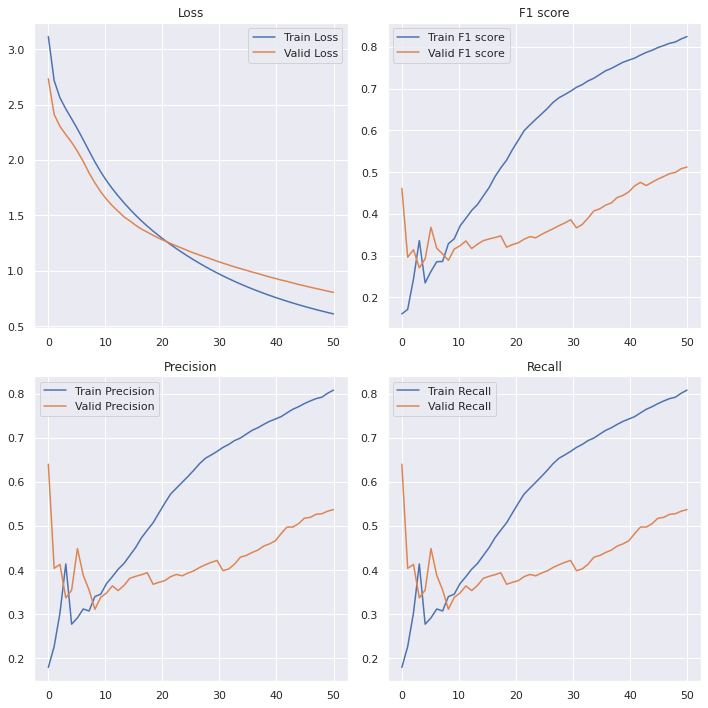

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()
x = np.linspace(0, N_EPOCHS,N_EPOCHS)
f = plt.figure(figsize=(10, 10))
gs = f.add_gridspec(2, 2)

t_l = res['loss_train']
v_l = res['loss_valid']

t_f1 = res['f1_avg_train'] 
v_f1 = res['f1_avg_valid'] 

t_p = res['p_avg_train'] 
v_p = res['p_avg_valid']

t_r = res['p_avg_train'] 
v_r = res['p_avg_valid']

with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0,0])
    plt.plot(x,t_l, label='Train Loss')
    plt.plot(x,v_l, label='Valid Loss')
    plt.title("Loss")
    plt.legend()
        
    ax = f.add_subplot(gs[0,1])
    plt.plot(x, t_f1, label='Train F1 score')
    plt.plot(x, v_f1, label='Valid F1 score')
    plt.title("F1 score")
    plt.legend()
    
    ax = f.add_subplot(gs[1,0])
    plt.plot(x, t_p, label='Train Precision')
    plt.plot(x, v_p, label='Valid Precision')
    plt.title("Precision")
    plt.legend()
    
    ax = f.add_subplot(gs[1,1])
    plt.plot(x, t_r, label='Train Recall')
    plt.plot(x, v_r, label='Valid Recall')
    plt.title("Recall")
    plt.legend()

       
f.tight_layout()

## Test

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predict =  preds
true =  labels

positive_labels = [i for i in range(len(rel2id)) if i != 0]
positive_names = [list(rel2id.keys())[list(rel2id.values()).index(i)] for i in range(len(rel2id)) if i != 0]
print(classification_report(
                y_true=true,
                y_pred=predict,
                labels=positive_labels,
                target_names=positive_names
            ))


                           precision    recall  f1-score   support

     hasattacktime(e1,e2)       0.78      0.68      0.73       266
         indicates(e2,e1)       0.70      0.85      0.77       756
  hasvulnerability(e1,e2)       0.44      0.78      0.56         9
           targets(e1,e2)       0.79      0.07      0.14       148
 hasattacklocation(e2,e1)       0.93      0.94      0.93       341
         belongsto(e2,e1)       0.54      0.78      0.64         9
 hasattacklocation(e1,e2)       0.96      0.98      0.97      1690
                    other       0.90      0.15      0.26       124
          exploits(e1,e2)       0.20      0.17      0.18        12
  hasvulnerability(e2,e1)       0.25      0.25      0.25         4
          exploits(e2,e1)       0.00      0.00      0.00         3
         indicates(e1,e2)       0.59      0.47      0.52       215
        hasproduct(e1,e2)       0.63      0.85      0.72       702
     hasattacktime(e2,e1)       0.60      0.66      0.63     

In [ ]:
import pandas as pd

confusion = confusion_matrix(true, predict)
l = positive_names

confusion_df =pd.DataFrame(confusion)

confusion_df.columns=l
s = pd.Series(l)
confusion_df = confusion_df.set_index([s])


confusion_df

## Références : 

 - https://www.aclweb.org/anthology/C16-1238.pdf